<a href="https://colab.research.google.com/github/faizuddin1995/Faizuddin_dissertation_code_2023/blob/main/NEWrobertawithfinetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#File authorization from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 83.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.6 MB/s eta 0:00:00


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in t

Epoch 1/3, Average Loss: 0.9882


Epoch 2/3: 100%|██████████| 1501/1501 [01:06<00:00, 22.43it/s]


Epoch 2/3, Average Loss: 0.6933


Epoch 3/3: 100%|██████████| 1501/1501 [01:07<00:00, 22.21it/s]


Epoch 3/3, Average Loss: 0.5701


Testing: 100%|██████████| 1001/1001 [00:14<00:00, 70.78it/s]


Polarity Distribution on Predicted Sentiments:
Very Negative: 27
Negative: 210
Neutral: 2130
Positive: 740
Very Positive: 894
Accuracy: 0.7798050487378155
Precision: 0.7735109604481566
Recall: 0.7798050487378155
F1 Score: 0.771635116720785


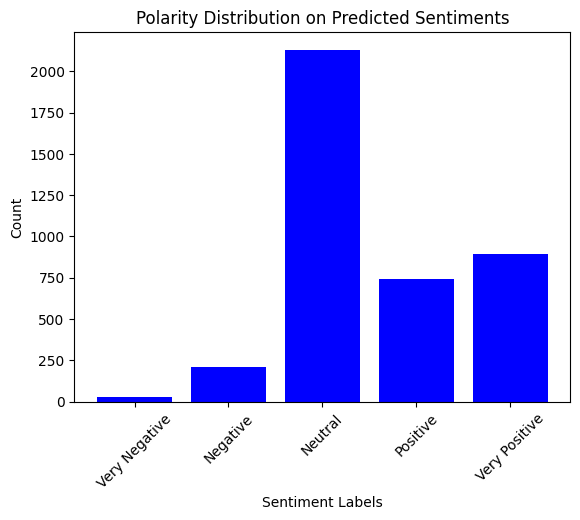

In [ ]:
!pip install transformers

import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the cleaned data
path = '/content/drive/MyDrive/data/new/cleaned_tweet_data.csv'
df = pd.read_csv(path, encoding='ISO-8859-1', on_bad_lines='skip')

# Define the RoBERTa model and tokenizer
model_name = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=5)

# Preprocess the data
texts = df['content'].tolist()
sentiments = df['sentiment_numeric'].tolist()

input_ids = []
attention_masks = []

for text in texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                      # Text to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
sentiments = torch.tensor(sentiments)

# Split data into train and test sets
train_inputs, test_inputs, train_masks, test_masks, train_sentiments, test_sentiments = train_test_split(
    input_ids, attention_masks, sentiments, test_size=0.4, random_state=42
)

# Create data loaders
batch_size = 4

train_data = TensorDataset(train_inputs, train_masks, train_sentiments)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

test_data = TensorDataset(test_inputs, test_masks, test_sentiments)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Set up optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
epochs = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

for epoch in range(epochs):
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
        batch = tuple(t.to(device) for t in batch)
        inputs, masks, labels = batch

        optimizer.zero_grad()

        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{epochs}, Average Loss: {average_loss:.4f}")

# Testing loop
model.eval()
test_preds = []
true_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        batch = tuple(t.to(device) for t in batch)
        inputs, masks, labels = batch

        outputs = model(inputs, attention_mask=masks)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        test_preds.extend(preds)
        true_labels.extend(labels.cpu().numpy())

# Calculate polarity distribution on test predictions
polarity_distribution = [test_preds.count(i) for i in range(5)]

print("Polarity Distribution on Predicted Sentiments:")
print("Very Negative:", polarity_distribution[0])
print("Negative:", polarity_distribution[1])
print("Neutral:", polarity_distribution[2])
print("Positive:", polarity_distribution[3])
print("Very Positive:", polarity_distribution[4])

# Calculate metrics using sklearn
accuracy = accuracy_score(true_labels, test_preds)
precision = precision_score(true_labels, test_preds, average='weighted')
recall = recall_score(true_labels, test_preds, average='weighted')
f1 = f1_score(true_labels, test_preds, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Plot the polarity distribution on a bar graph
sentiment_labels = ["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"]

plt.bar(sentiment_labels, polarity_distribution, color='blue')
plt.xlabel("Sentiment Labels")
plt.ylabel("Count")
plt.title("Polarity Distribution on Predicted Sentiments")
plt.xticks(rotation=45)
plt.show()